# SAMPLE DATA: Airline Survey
Источник данных: https://www.ibm.com/communities/analytics/watson-analytics-blog/sample-data-airline-survey/

In [8]:
# Загружаем библиотеки
import numpy as np # работа с векторами
import pandas as pd # для работы с матрицами
import xlrd # для считывания файлов Эксель
import warnings
warnings.filterwarnings('ignore')
import scipy.stats # для статистик
import seaborn as sns
from pylab import rcParams
%matplotlib inline
sns.set_style("ticks")
rcParams['figure.figsize'] = 15, 9

In [2]:
# загружаем данные
data_xls = pd.read_excel('Satisfaction Survey.xlsx', 'Sheet1', index_col=None)
data_xls.to_csv('Satisfaction Survey.csv', encoding='utf-8', index=False)
dataset = pd.read_csv('Satisfaction Survey.csv', low_memory=False) 

In [3]:
print(dataset.shape)
print(dataset.columns)

(129889, 30)
Index(['Satisfaction', 'Airline Status', 'Age', 'Age Range', 'Gender',
       'Price Sensitivity', 'Year of First Flight', 'No of Flights p.a.',
       'No of Flights p.a. grouped', '% of Flight with other Airlines',
       'Type of Travel', 'No. of other Loyalty Cards',
       'Shopping Amount at Airport', 'Eating and Drinking at Airport', 'Class',
       'Day of Month', 'Flight date', 'Airline Code', 'Airline Name',
       'Orgin City', 'Origin State', 'Destination City', 'Destination State',
       'Scheduled Departure Hour', 'Departure Delay in Minutes',
       'Arrival Delay in Minutes', 'Flight cancelled',
       'Flight time in minutes', 'Flight Distance',
       'Arrival Delay greater 5 Mins'],
      dtype='object')


Датасет содержит 129889 наблюдений по 30 факторам и описывает Удовлетворённость аэропассажиров; содержит информацию:
* 'Satisfaction' - оценка удовлетворённости пассажира (от 0 до 5)
* 'Airline Status' - статус клиента (Blue, Silver, Gold, Platinum)
* 'Age', - возраст клиента
* 'Age Range' - возрастная группа (по десятилетиям)
* 'Gender' - пол (М или Ж)
* 'Price Sensitivity' - чувствительность к цене билета (от 0 до 5)
* 'Year of First Flight' - год первого полёта (2003-2012)
* 'No of Flights p.a.' - среднее количество полётов в год (от 0 до 100)
* 'No of Flights p.a. grouped' - группа по количеству полётов (по десяткам)
* '% of Flight with other Airlines' - доля полётов с другими авиалиниями
* 'Type of Travel' - тип полёта (Business travel, Personal Travel, Mileage tickets)
* 'No. of other Loyalty Cards' - количество карт лольности других авиалиний
* 'Shopping Amount at Airport' - стоимость покупок в аэропорту
* 'Eating and Drinking at Airport' - траты на еду и напитки в аэропорту
* 'Class' - класс билета (Business, Eco, Eco Plus)
* 'Day of Month' - день месяца
* 'Flight date' - дата полёта
* 'Airline Code'  - код авиалинии
* 'Airline Name' - название авиалинии
* 'Orgin City' - город вылета
* 'Origin State' - штат вылета
* 'Destination City' - город прилёта
* 'Destination State' - штат прилёта
* 'Scheduled Departure Hour' - запланированное время вылета
* 'Departure Delay in Minutes' - задержка вылета (в мин.)
* 'Arrival Delay in Minutes' - задержка посадки (в мин.)
* 'Flight cancelled' - рейс отменен (да/нет)
* 'Flight time in minutes' - длительность полёта (в мин.)
* 'Flight Distance' - расстояние (в милях)
* 'Arrival Delay greater 5 Mins' - задержка дольше 5 минут (да/нет)

Основная задача исследования: выявить взаимосвязи между характеристиками пассажиров (как субъективной составляющей), длительностью задержки рейса (как объективной составляющей) и оценкой удовлетворённости. Сравнить и объяснить влияние субъективных и объективных аспектов на формирование клиентами мнения о качестве предоставляемых авиакомпанией услуг. В дальнейшем полученные знания можно будет использовать для выделения клиентских групп и формирования персонализированных предложений, направленных на повышение их удовлетворённости. К примеру, путём раннего информирования о предстоящих акциях, можно мотивировать молодых людей путешествовать чаще (Age 18-30, Type of travel -- Personal travel, Class -- Eco / Eco Plus). 

Оставим для анализа следующие показатели: 'Satisfaction', 'Airline Status', 'Age', 'Gender', 'Price Sensitivity', 'No of Flights p.a.', 'Type of Travel', 'Class', 'Departure Delay in Minutes', 'Flight time in minutes'. 

In [4]:
dt = dataset.copy()
# уберём факторы, не участвующие в анализе
dt = dt.drop(['Year of First Flight', '% of Flight with other Airlines', 'No. of other Loyalty Cards', 
          'Shopping Amount at Airport', 'Eating and Drinking at Airport', 'Day of Month', 'Flight date', 'Airline Code',
          'Origin State', 'Orgin City', 'Destination City', 'Destination State', 'Scheduled Departure Hour', 'Age Range',
          'No of Flights p.a. grouped', 'Flight Distance', 'Arrival Delay greater 5 Mins', 'Airline Name', 'Flight cancelled'], axis=1)

#уберём строки, содержащие некорректные значения Satisfaction
dt = dt.drop(dt.index[38897:38900], axis=0)

# создадим dummy переменные для категориальных признаков
dt = pd.concat([dt, pd.get_dummies(dt['Airline Status']), pd.get_dummies(dt['Gender'])], axis=1, sort=False)
dt = pd.concat([dt, pd.get_dummies(dt['Type of Travel']), pd.get_dummies(dt['Class'])], axis=1, sort=False)
dt = dt.drop(['Airline Status', 'Gender', 'Type of Travel', 'Class', 'Female'], axis=1)
for column in ['Blue', 'Gold', 'Platinum', 'Silver', 'Male', 'Business travel', 
               'Mileage tickets', 'Personal Travel', 'Business', 'Eco', 'Eco Plus']:
    dt[column] = dt[column].astype('bool')
dt['Satisfaction'] = dt['Satisfaction'].astype('float')
dt = dt.drop(['Arrival Delay in Minutes', 'Silver', 'Personal Travel', 'Eco'], axis=1)

# уберём строки, содержащие дробные значения Satisfaction (таких всего 6)
dt = dt.drop(dt[((dt['Satisfaction'] % 1 ) !=0)].index, axis=0)
dt = dt.dropna()

names = ['Satisfaction', 'Age', 'Price Sensitivity', 'No of Flights p.a.',
       'Departure Delay in Minutes', 'Flight time in minutes', 'Blue', 'Gold',
       'Platinum', 'Male', 'Business travel', 'Mileage tickets', 'Business','Eco Plus']

In [5]:
dt.describe()

,Satisfaction,Age,Price Sensitivity,No of Flights p.a.,Departure Delay in Minutes,Flight time in minutes
count,127143.000000,127143.000000,127143.000000,127143.000000,127143.000000,127143.000000
mean,3.384292,46.162455,1.274966,20.049687,14.913350,111.515207
std,0.966562,17.262393,0.546174,14.350686,38.228314,71.777375
min,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
25%,3.000000,33.000000,1.000000,8.716876,0.000000,59.000000
50%,4.000000,45.000000,1.000000,17.294282,0.000000,92.000000
75%,4.000000,58.000000,2.000000,28.730823,13.000000,142.000000
max,5.000000,85.000000,5.000000,100.000000,1592.000000,669.000000


In [6]:
dt.describe(include=['object', 'bool'])

,Blue,Gold,Platinum,Male,Business travel,Mileage tickets,Business,Eco Plus
count,127143,127143,127143,127143,127143,127143,127143,127143
unique,2,2,2,2,2,2,2,2
top,True,False,False,False,True,False,False,False
freq,86848,116473,123052,71683,78379,117326,116691,113827


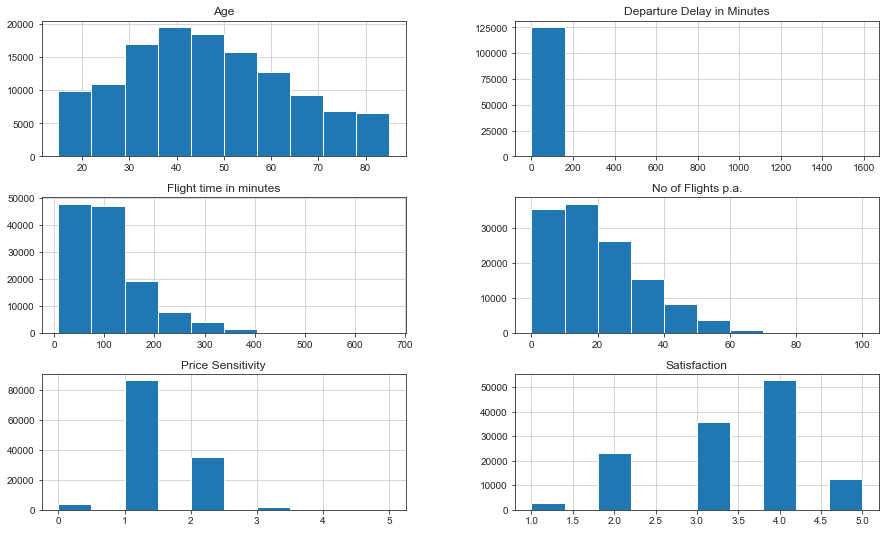

In [9]:
dt[['Satisfaction', 'Age', 'Price Sensitivity', 'No of Flights p.a.',
       'Departure Delay in Minutes', 'Flight time in minutes', ]].hist();

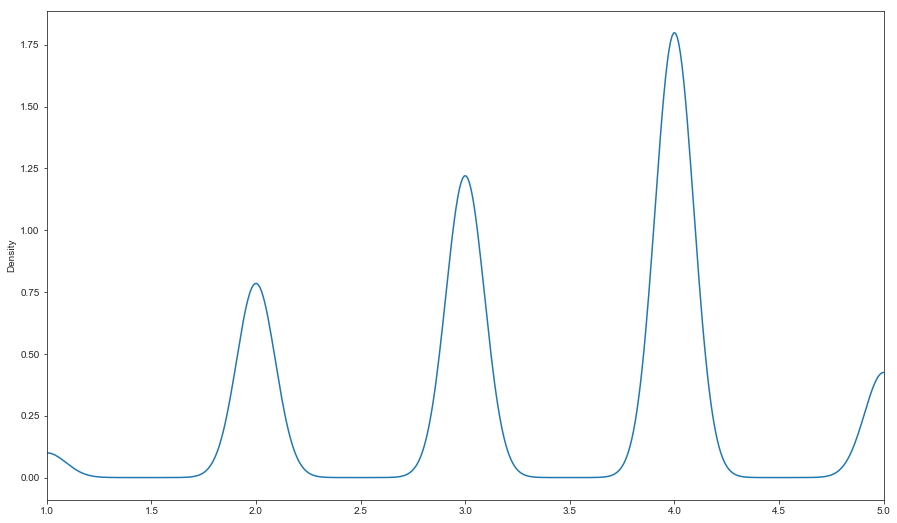

In [10]:
dt["Satisfaction"].plot("kde", xlim=(dt["Satisfaction"].min(), dt["Satisfaction"].max()));

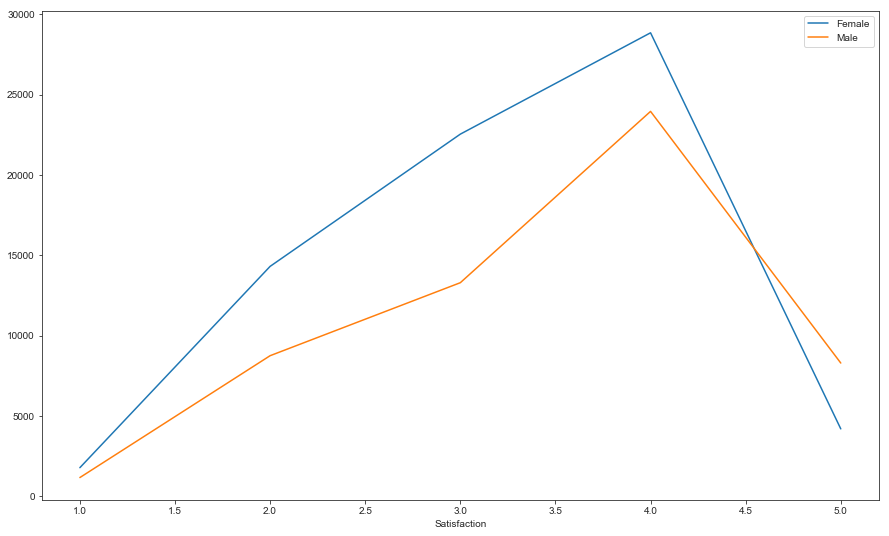

In [11]:
fig = dt[["Satisfaction", "Male"]].pivot_table(index=["Satisfaction"], columns=["Male"], aggfunc=len).plot()
fig.legend(["Female", "Male"]);

In [12]:
print(dt[dt['Male']==1].mean()['Satisfaction'] - dt[dt['Male']==0].mean()['Satisfaction'])
print(dt[dt['Male']==1].mean()['Departure Delay in Minutes'] - dt[dt['Male']==0].mean()['Departure Delay in Minutes'])

0.26116530362052703
0.34487489920801195


В среднем клиенты мужского пола оценивают свою удовлетворённость от услуг авиакомпании на 0,26 баллов (из 5) выше, чем женщины. При этом средняя длительность задержки рейса у мужчин на 0,34 минуты больше. 

In [13]:
dt.corr()

,Satisfaction,Age,Price Sensitivity,No of Flights p.a.,Departure Delay in Minutes,Flight time in minutes,Blue,Gold,Platinum,Male,Business travel,Mileage tickets,Business,Eco Plus
Satisfaction,1.000000,-0.221987,-0.088288,-0.238801,-0.073379,-0.003736,-0.338640,0.114974,0.052008,0.133996,0.521134,0.046898,0.046700,-0.022063
Age,-0.221987,1.000000,-0.067263,0.245750,0.000553,-0.001213,-0.020073,0.042816,0.040695,-0.041800,-0.267658,-0.095799,-0.012038,0.018166
Price Sensitivity,-0.088288,-0.067263,1.000000,0.011125,-0.001037,0.003425,0.091420,-0.044868,-0.037937,-0.019938,-0.100562,0.040821,-0.002776,-0.039525
No of Flights p.a.,-0.238801,0.245750,0.011125,1.000000,-0.000970,-0.000739,0.146221,-0.071033,-0.050043,0.071409,-0.292984,0.042274,-0.006961,-0.076460
Departure Delay in Minutes,-0.073379,0.000553,-0.001037,-0.000970,1.000000,0.005792,0.001654,-0.000628,-0.001636,0.004474,0.001064,0.004893,0.002555,-0.004540
Flight time in minutes,-0.003736,-0.001213,0.003425,-0.000739,0.005792,1.000000,0.002832,0.001096,0.000728,0.005937,-0.000797,0.002099,0.002122,-0.002148
Blue,-0.338640,-0.020073,0.091420,0.146221,0.001654,0.002832,1.000000,-0.444349,-0.267685,-0.025710,-0.152916,0.053466,-0.018800,0.035949
Gold,0.114974,0.042816,-0.044868,-0.071033,-0.000628,0.001096,-0.444349,1.000000,-0.055187,-0.010254,0.064833,-0.027721,0.009486,-0.014590
Platinum,0.052008,0.040695,-0.037937,-0.050043,-0.001636,0.000728,-0.267685,-0.055187,1.000000,0.066013,0.060226,-0.019348,0.009686,-0.024083
Male,0.133996,-0.041800,-0.019938,0.071409,0.004474,0.005937,-0.025710,-0.010254,0.066013,1.000000,0.115267,0.010565,0.025453,-0.139403


In [14]:
c = dt.corr().abs()
s = c.unstack()
so = s.sort_values(kind="quicksort", na_position='first')
print(so[-15:-14])

Satisfaction  Business travel    0.521134
dtype: float64


Согласно коэффициенту корреляции, наибольшая взаимосвязь наблюдается между удовлетворённостью клиента и тем фактом, что он путешествует по бизнесу. Связь прямая, что подразумевает: бизнес-пассажиры более удовлетворены, чем иные группы (Personal Travel и Mileage tickets). Проверим гипотезу, что влияние Business travel на удовлетворённость клиента является статистически значимым:

In [15]:
# Н0: влияние Business travel на удовлетворённость клиента является статистически значимым. (отвергается)
scipy.stats.chisquare(dt['Business travel'], dt['Satisfaction'])

Power_divergenceResult(statistic=295703.1, pvalue=0.0)

Гипотеза отвергается (при α=0.05). 

## Gradient Boosting

Построим модель для выявления множественных взаимосвязей внутри данных. Модель основана на градиентном бустинге. Разделим данные на тренировочную и тестовую выборки, а также на предикторы и прогнозируемое значение - удовлетворённость.

In [16]:
X = dt.iloc[:, 1:].values
y = dt.iloc[:, 0].values

from sklearn import model_selection
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state = 0)

Обучим алгоритм и проверим долю правильных ответов, а также проведём кросс-валидацию.

In [17]:
from sklearn.ensemble import GradientBoostingClassifier
modelGB = GradientBoostingClassifier(n_estimators=150)
modelGB.fit(X_train, y_train)
print("Доля правильных ответов на обучающей выборке:", 
      round(modelGB.score(X_train, y_train), 3))
print("Доля правильных ответов на тестовой выборке:", 
      round(modelGB.score(X_test, y_test), 3))
results = model_selection.cross_val_score(modelGB, X_train, y_train, cv=3)
print("Средний результат кросс-валидации:", 
      round(results.mean(), 3))

Доля правильных ответов на обучающей выборке: 0.6
Доля правильных ответов на тестовой выборке: 0.586
Средний результат кросс-валидации: 0.59


Полученная точность предсказаний является сравнительно низкой и не позволяет использовать модель для достоверного прогнозирования. Однако рассмотрим выявленные взаимосвязи и интерпретируем результаты:

In [18]:
import eli5
eli5.show_weights(modelGB, feature_names=names[1:])

Weight,Feature
0.4017 ± 0.2783,Business travel
0.1698 ± 0.2095,Mileage tickets
0.1508 ± 0.2691,Blue
0.1042 ± 0.3577,Age
0.0714 ± 0.3184,Departure Delay in Minutes
0.0290 ± 0.1787,Platinum
0.0277 ± 0.1971,Male
0.0268 ± 0.1936,Gold
0.0100 ± 0.3990,No of Flights p.a.
0.0050 ± 0.3255,Flight time in minutes


Наибольшее влияние на полученную модель оказывает переменная Business travel, что в рамках модели означает: принадлежность человека к группе бизнес-пассажиров оказывает значимое влияние на степень его удовлетворённости. То же касается и параметра Mileage tickets: приобретён ли билет за счёт накопленных миль влияет на удовлетворённость пассажира. Описанные связи являются глобальной характеристикой модели, рассмотрим теперь связи на единичных случайных примерах:

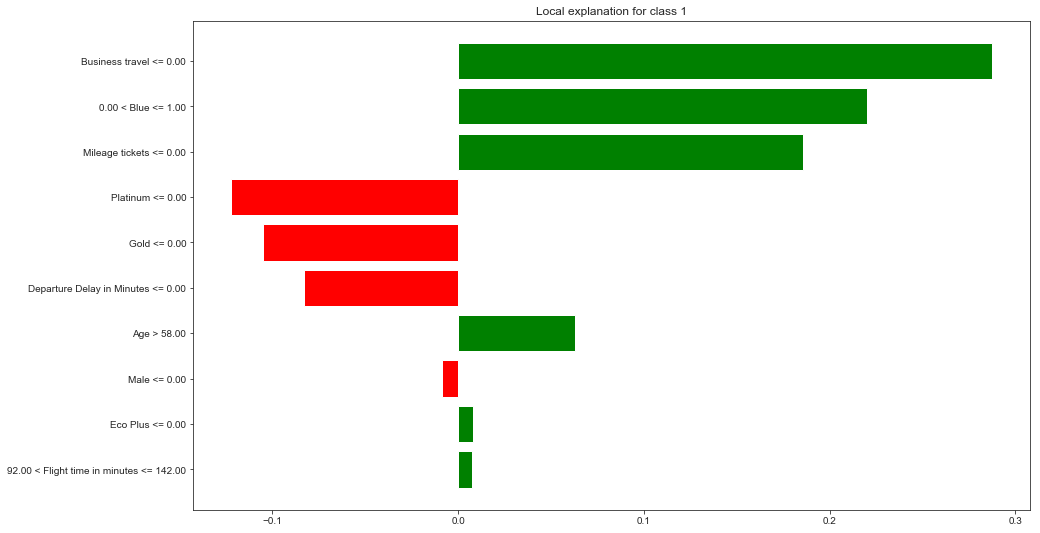

In [19]:
import lime
import random
random.seed(1)
from lime.lime_tabular import LimeTabularExplainer
explainer = LimeTabularExplainer(X_train, mode='classification', 
                                 feature_names=names[1:])
exp = explainer.explain_instance(X_test[random.randint(0, len(X_test)),:], modelGB.predict_proba)
exp.as_pyplot_figure();

Согласно модели, в окрестностях данного примера можно говорить о том, что удовлетворенность клиента значительно возрастёт, если перевести его в категорию бизнес-поездки; возрастёт - если он в категории Blue, если этот билет окажется за накопленные мили. Удовлетворённость снизится, если статус клиента станет Platinum или Gold, если рейс задержат. Удовлетворённость повышается с увеличением возраста пассажира от 58 лет.

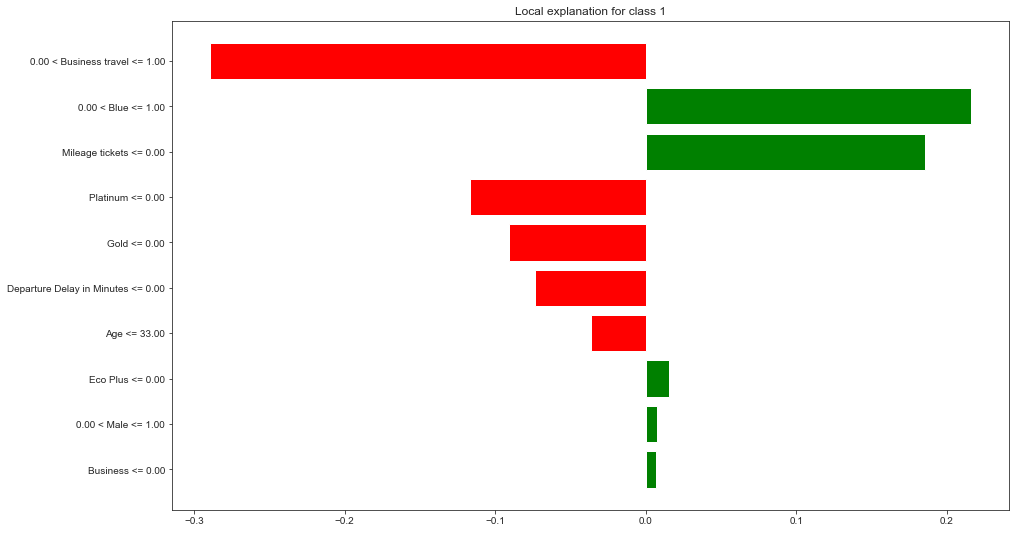

In [20]:
random.seed(2)
explainer = LimeTabularExplainer(X_train, mode='classification', 
                                 feature_names=names[1:])
exp = explainer.explain_instance(X_test[random.randint(0, len(X_test)),:], modelGB.predict_proba)
exp.as_pyplot_figure();

Данный пример показывает, что изменение класса бизнес-поездки у пассажира на любой другой вызовет отрицательную реакцию. Пассажир положительно среагирует на изменение типа билета на Mileage tickets и отрицательно - на изменение статуса на Platinum или Gold, любую задержку рейса и старение от 33 лет.

## Causal Inference

Отойдём от модели и проанализируем каузальные связи, имеющиеся в данных. Рассмотрим связь между удовлетворённостью клиентов и фактом бизнес-поездки. Данная связь характеризуется как наиболее сильная согласно парному коэффициенту корреляции (0.521), и имеет наибольший вес в модели градиентного бустинга (вес=0.4017).

In [21]:
Y = dt['Satisfaction'].values
D = dt['Business travel'].values
X = dt['Age'].values
from causalinference import CausalModel
causal = CausalModel(Y, D, X)
print(causal.summary_stats)


Summary Statistics

                     Controls (N_c=48764)       Treated (N_t=78379)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        2.746        0.860        3.782        0.802        1.036

                     Controls (N_c=48764)       Treated (N_t=78379)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0       52.020       20.798       42.518       13.403       -0.543



Для взаимосвязи параметров "удовлетворённость" и "бизнес-путешествие" исходная разница составляла 1.036, а с учётом влияния фактора "возраст" разница снизилась до 0.988 (на менее 5%). Разницу можно трактовать как величину, на которую изменится удовлетворённость пассажира, при переводе класса поездки в категорию Business travel. Проведём блокинг влияния этого фактора через возраст и посмотрим на изменения:

In [22]:
causal.est_propensity()
causal.stratify()
causal.est_via_blocking(adj=0)
print(causal.estimates)


Treatment Effect Estimates: Blocking

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.885      0.006    157.944      0.000      0.874      0.896
           ATC      0.881        nan        nan        nan        nan        nan
           ATT      0.888      0.011     81.307      0.000      0.866      0.909



При блокинге разница в удовлетворённости между группами бизнес-путешественников и иных, с учётом возраста, составляет 0.885 (снизилась от исходной на менее 15%). Это говорит об определённом влиянии возраста как на удовлетворённость, так и на принадлежность пассажира к категории Business travel. 

Вспомним раннее наблюдение: "В среднем клиенты мужского пола оценивают свою удовлетворённость от услуг авиакомпании на 0,26 баллов (из 5) выше, чем женщины. При этом средняя длительность задержки рейса у мужчин на 0,34 минуты больше". Проверим его с помощью метода наименьших квадратов. Отследим влияние пола на удовлетворённость с учётом длительности задержки рейса.

In [23]:
Y = dt['Satisfaction'].values
D = dt['Male'].values
X = dt['Departure Delay in Minutes'].values
causal2 = CausalModel(Y, D, X)
print(causal2.summary_stats)


Summary Statistics

                     Controls (N_c=71683)       Treated (N_t=55460)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        3.270        0.928        3.532        0.995        0.261

                     Controls (N_c=71683)       Treated (N_t=55460)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0       14.763       37.935       15.108       38.604        0.009



In [24]:
causal2.est_via_ols()
print(causal2.estimates)


Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.262      0.005     48.038      0.000      0.251      0.272
           ATC      0.262      0.005     48.035      0.000      0.251      0.272
           ATT      0.262      0.005     48.041      0.000      0.251      0.273



Исходная разница 0.26 совпадает с нашим наблюдением на основании среднего значения, так как переменная логическая. Мужчины на 0.26 баллов оценивают удовлетворённость выше. Стоит отметить, что при дополнительном учёте длительности задержки рейса разница практически не изменяется. Это означает, что фактор задержки не влияет на связь между полом и удовлетворённостью. 

## Выводы

Результаты: На основе проведённого анализа была установлена взаимосвязь между удовлетворённостью пассажиров и фактом бизнес-поездки. Также замечено, что в среднем мужчины более удовлетворены услугами авиакомпании, на что не влияет задержка рейса. Построенная модель градиентного бустинга указывает на значимое влияние как факта бизнес-поездки, так и параметров Mileage tickets (приобретён ли билет за счёт накопленных миль), Blue (статуса клиента), возраста и длительности задержки рейса. Анализ причинных связей показал определённую связь между удовлетворённостью, фактом бизнес-поездки и возрастом одновременно.

Практическая ценность полученных знаний заключается в понимании базовых взаимосвязей между удовлетворённостью клиентов и субъективными факторами, которые их описывают. Согласно результатам, объективный фактор - длительность задержки рейса, играет не столь большую роль в оценке качества услуг компании, сколько ряд характеристик того или иного пассажира. Однако это не значит, что самоолёты могут чаще опаздывать без последствий для имиджа компании и лояльности клиентов. 